In [6]:
import requests
import datetime
import pandas as pd
import boto3
import os
from botocore.exceptions import NoCredentialsError

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline



ModuleNotFoundError: No module named 'mypy_extensions'

# Download the dataset

In [97]:

os.environ["AWS_PROFILE"] = "mac2aws" 
# Initialize a session using Amazon S3
session = boto3.Session(profile_name='mac2aws')

try:
    # Initialize a session using Amazon S3
    s3 = session.client('s3')

    # Define the bucket and file
    bucket_name = 'mlflow-artifacts-evs'
    file_key = 'data/energy_forecast.csv'
    file_name = 'energy_forecast.csv'
    download_path = f'./data/{file_name}'

    # Download the file
    s3.download_file(bucket_name, file_key, download_path)

    print(f"File downloaded to {download_path}")

except boto3.exceptions.S3UploadFailedError as e:
    print(f"Failed to download file from S3: {e}")
except boto3.exceptions.S3DownloadFailedError as e:
    print(f"Failed to download file from S3: {e}")
except boto3.exceptions.Boto3Error as e:
    print(f"An error occurred with boto3: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Read the dataset

In [ ]:
try:
    # Get the current working directory
    notebook_dir = os.getcwd()

    # Define the file path
    file_path = os.path.join(notebook_dir, download_path)

    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    print(f"File loaded successfully: {file_path}")

except FileNotFoundError as e:
    print(e)
except pd.errors.EmptyDataError:
    print(f"The file {file_path} is empty or cannot be read.")
except pd.errors.ParserError:
    print(f"Error parsing the file {file_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



In [ ]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [99]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://ec2-3-14-112-137.us-east-2.compute.amazonaws.com:5000'


In [100]:
mlflow.search_experiments() # list_experiments API has been removed, you can use search_experiments instead.()

[<Experiment: artifact_location='s3://mlflow-artifacts-evs/3', creation_time=1723952998415, experiment_id='3', last_update_time=1723952998415, lifecycle_stage='active', name='my-experiment-3', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/2', creation_time=1723492994445, experiment_id='2', last_update_time=1723492994445, lifecycle_stage='active', name='my-experiment-2', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/1', creation_time=1723478188985, experiment_id='1', last_update_time=1723478188985, lifecycle_stage='active', name='my-experiment-1', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/0', creation_time=1723466290987, experiment_id='0', last_update_time=1723466290987, lifecycle_stage='active', name='Default', tags={}>]

In [101]:
mlflow.set_experiment("energy-prediction-pipeline")

2024/08/18 01:14:55 INFO mlflow.tracking.fluent: Experiment with name 'energy-prediction-pipeline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-artifacts-evs/4', creation_time=1723958095275, experiment_id='4', last_update_time=1723958095275, lifecycle_stage='active', name='energy-prediction-pipeline', tags={}>

In [102]:
df_filtered['created_date'] = pd.to_datetime(df_filtered['created_date'])
df_filtered['day_of_week'] = df_filtered['created_date'].dt.dayofweek
df_filtered['month'] = df_filtered['created_date'].dt.month
df_filtered['day'] = df_filtered['created_date'].dt.day
df_filtered['year'] = df_filtered['created_date'].dt.year
df_filtered['Sta_Loc'] = df_filtered['stationId'].astype(str) + '_' + df_filtered['locationId'].astype(str)



In [103]:
features = ['day_of_week', 'month', 'day', 'year', 'created_date', 'chargeTimeHrs', 'distance', 'Sta_Loc','stationId', 'locationId']

X = df_filtered[features]
y = df_filtered['kwhTotal']

In [104]:
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
# Convert Timestamps to strings
df_train['created_date'] = df_train['created_date'].astype(str)
df_test['created_date'] = df_test['created_date'].astype(str)


In [106]:
# Convert DataFrame rows to dictionaries
df_train_dicts = df_train.to_dict(orient='records')
df_test_dicts = df_test.to_dict(orient='records')

# dv = DictVectorizer()

# # Fit and transform the training data
# X_train = dv.fit_transform(df_train_dicts)

# # Transform the test data
# X_test = dv.transform(df_test_dicts)

In [107]:

# Start the MLflow run
with mlflow.start_run() as run:
    mlflow.log_param("model_type", "RandomForest")

    # Log the model parameters
    params = dict(max_depth=20, n_estimators=100, min_samples_leaf=10, random_state=42)
    mlflow.log_params(params)
    
    pipeline = make_pipeline(
        DictVectorizer(),
        RandomForestRegressor(**params, n_jobs=-1)
    )

    pipeline.fit(df_train_dicts, y_train)
    y_pred = pipeline.predict(df_test_dicts)

    # Calculate and log metrics
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(params, rmse, r2)

    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric("r2", r2)

    # Log the model
    mlflow.sklearn.log_model(pipeline, artifact_path="models")

    # with open ('./models/xgboost_energy_model_dv.bin', 'wb') as f_out:
    #     pickle.dump((dv, model), f_out)
    # mlflow.log_artifact('xgboost_energy_model_dv.bin')



{'max_depth': 20, 'n_estimators': 100, 'min_samples_leaf': 10, 'random_state': 42} 1.3126383107031125 0.6809872003804309


In [108]:
mlflow.search_experiments()


[<Experiment: artifact_location='s3://mlflow-artifacts-evs/4', creation_time=1723958095275, experiment_id='4', last_update_time=1723958095275, lifecycle_stage='active', name='energy-prediction-pipeline', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/3', creation_time=1723952998415, experiment_id='3', last_update_time=1723952998415, lifecycle_stage='active', name='my-experiment-3', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/2', creation_time=1723492994445, experiment_id='2', last_update_time=1723492994445, lifecycle_stage='active', name='my-experiment-2', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/1', creation_time=1723478188985, experiment_id='1', last_update_time=1723478188985, lifecycle_stage='active', name='my-experiment-1', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/0', creation_time=1723466290987, experiment_id='0', last_update_time=1723466290987, lifecycle_stage='active', name='De

## Interacting with the model registry


In [109]:
from mlflow.tracking import MlflowClient


# Initialize MLflow client
client = MlflowClient(f"http://{TRACKING_SERVER_HOST}:5000")

In [110]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1723799381714, description='', last_updated_timestamp=1723799381714, latest_versions=[], name='2kjaF0EfT4lHTkS4fGTgPoCs8ZF', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1723500706238, description='', last_updated_timestamp=1723953766893, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1723953766893, current_stage='None', description='', last_updated_timestamp=1723953766893, name='Energy forecast', run_id='0d47116c16d74459bc2e1ea950919e6c', run_link='', source='s3://mlflow-artifacts-evs/3/0d47116c16d74459bc2e1ea950919e6c/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='13'>], name='Energy forecast', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1723501687908, description='', last_updated_timestamp=1723501688082, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1723501688082, current_stage='None', description='', last_updated_timestamp=1723501688

### Regester an empty model with no version associated

In [111]:
registered_name = 'Energy forecast'
model_uri = f"runs:/{run.info.run_id}/models"

# Register an empty registered model with no version associated
try:
    result = mlflow.register_model(
        model_uri=model_uri,
        name=registered_name
    )
    print(f"Model registered with version: {result.version}")
except Exception as e:
    print(f"An error occurred: {e}")
print(f"Name: {result.name}")
print(f"Version: {result.version}")

Registered model 'Energy forecast' already exists. Creating a new version of this model...
2024/08/18 01:15:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Energy forecast, version 14


Model registered with version: 14
Name: Energy forecast
Version: 14


Created version '14' of model 'Energy forecast'.


### Regester a new version of the model (when incremental development)
With the version information, such as `tags` and `description`.

In [112]:

# # Define model details
# name = 'Energy usage forecast'
# model_uri = f"runs:/{run.info.run_id}/models"

# tags = {"Energy_Forecast": "Randomforest"}
# desc = "This is the forecasting model to predict the energy usage."

# from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository

# try:
#     # Register model name in the model registry
#     client.create_registered_model(name)

#     # Create a new version of the model under the registered model name
#     model_src = RunsArtifactRepository.get_underlying_uri(model_uri)
#     client.create_model_version(name = name, source = model_src, run_id = run.info.run_id, tags=tags, description = desc)

#     print(f"New registered model '{name}' created.")
# except mlflow.exceptions.MlflowException as e:
#     if "RESOURCE_ALREADY_EXISTS" in str(e):
#          print(f"Model '{name}' already exists")




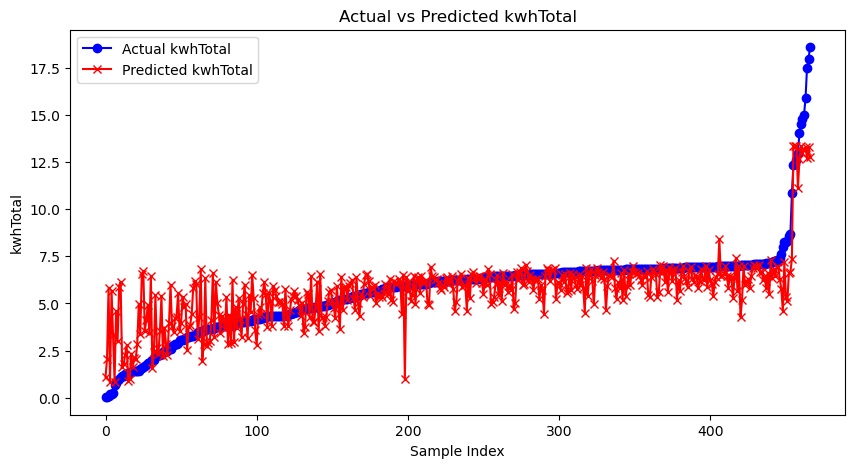

In [113]:
# Sort the actual and predicted values for better line plotting
sorted_indices = np.argsort(y_test.values)
sorted_y_test = y_test.values[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(sorted_y_test, label='Actual kwhTotal', color='blue', linestyle='-', marker='o')

# Plot predicted values
plt.plot(sorted_y_pred, label='Predicted kwhTotal', color='red', linestyle='-', marker='x')

plt.xlabel('Sample Index')
plt.ylabel('kwhTotal')
plt.title('Actual vs Predicted kwhTotal')
plt.legend()
plt.show()

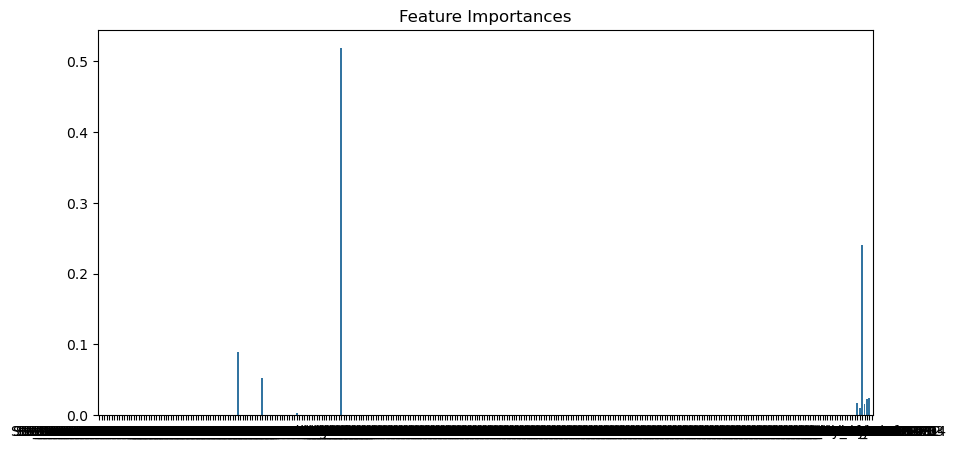

In [114]:

importances = model.feature_importances_
features = dv.get_feature_names_out()

plt.figure(figsize=(10, 5))
sns.barplot(x=features , y=importances)
plt.title('Feature Importances')
plt.show()